In [1]:
from pyexpat import features
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from aiohttp.web_routedef import static
from mpmath import residual

df = pd.read_csv("/Users/lorenzoreinoso/Documents/MIT-StreetCar-Delay/dataset_with_has_delay.csv")

In [2]:
df.head(10)

,Week,Line,Location,Incident,Min Delay,Min Gap,Vehicle,has_delay,Year,Month,Day_of_Month,Hour,Minute,Bound_B,Bound_E,Bound_N,Bound_S,Bound_W
0,1,0.126664,0.000992,11,10,20,4416,0,2024,1,1,2,45,0,0,0,0,1
1,1,0.126664,0.000361,3,52,72,4461,1,2024,1,1,3,6,0,1,0,0,0
2,1,0.064381,0.000180,11,0,0,4545,0,2024,1,1,3,21,0,0,1,0,0
3,1,0.126664,0.020566,11,37,0,4551,1,2024,1,1,3,53,0,0,0,0,1
4,1,0.002645,0.005412,2,78,93,8116,1,2024,1,1,4,27,0,1,0,0,0
5,1,0.203903,0.000090,2,74,84,3531,1,2024,1,1,4,33,0,1,0,0,0
6,1,0.203903,0.000631,2,39,49,4516,1,2024,1,1,4,39,0,0,0,0,1
7,1,0.031826,0.009832,4,6,18,4479,0,2024,1,1,4,52,0,1,0,0,0
8,1,0.104049,0.000722,4,13,28,4408,0,2024,1,1,4,53,0,1,0,0,0
9,1,0.203903,0.009832,4,15,30,4411,0,2024,1,1,4,54,0,0,0,0,1


In [3]:
df = df[df["has_delay"]==1]

In [4]:
# Function created for aesthetic, if we have more than 3 values it adds a ...
def format_unique_values(values):
    if len(values) > 3:
        return f"{list(values[:3])} ... ({len(values)} unique values)"
    return list(values)

# This is added for structure
summary = {
    'Data Type': df.dtypes, # Luego el tipo de dato
    'Unique Values': [df[col].nunique() for col in df.columns], # luego el número de valores unicos
    'Sample Values': [format_unique_values(df[col].unique()) for col in df.columns], # Usando la función de arriba mostrar algunos valores
    'Missing Values': df.isnull().sum(), # Cantidad de valores Faltantes
    'Missing %': round(df.isnull().sum() / len(df) * 100,2) # Es la proporción cuantos valores hay faltantes
}

details = pd.DataFrame(summary)

# This part is added to format the final table
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 1000)
styled_details = details.style.set_properties(**{
    'text-align': 'left',
    'white-space': 'pre-wrap'
}).set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#f0f0f0'),
                                ('color', 'black'),
                                ('font-weight', 'bold'),
                                ('text-align', 'left'),
                                ('padding', '8px')]},
    {'selector': 'td', 'props': [('padding', '8px')]}
])

display(styled_details)

# Final Resume
print("\nShape of the DF (rows, columns):", df.shape)
print(f"Rows: {df.shape[0]}")
print(f"Columns: {df.shape[1]}")

,Data Type,Unique Values,Sample Values,Missing Values,Missing %
Week,int64,40,"[1, 2, 3] ... (40 unique values)",0,0.000000
Line,float64,22,"[0.1266642349078971, 0.002644538, 0.2039029728250957] ... (22 unique values)",0,0.000000
Location,float64,74,"[0.000360815, 0.0205664802453545, 0.005412232] ... (74 unique values)",0,0.000000
Incident,int64,13,"[3, 11, 2] ... (13 unique values)",0,0.000000
Min Delay,int64,181,"[52, 37, 78] ... (181 unique values)",0,0.000000
Min Gap,int64,194,"[72, 0, 93] ... (194 unique values)",0,0.000000
Vehicle,int64,405,"[4461, 4551, 8116] ... (405 unique values)",0,0.000000
has_delay,int64,1,[1],0,0.000000
Year,int64,1,[2024],0,0.000000
Month,int64,9,"[1, 2, 3] ... (9 unique values)",0,0.000000



Shape of the DF (rows, columns): (2271, 18)
Rows: 2271
Columns: 18


Some the key aspects are that there are no categorical Values, also we can identify that there are no missing values.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2271 entries, 1 to 11071
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Week          2271 non-null   int64  
 1   Line          2271 non-null   float64
 2   Location      2271 non-null   float64
 3   Incident      2271 non-null   int64  
 4   Min Delay     2271 non-null   int64  
 5   Min Gap       2271 non-null   int64  
 6   Vehicle       2271 non-null   int64  
 7   has_delay     2271 non-null   int64  
 8   Year          2271 non-null   int64  
 9   Month         2271 non-null   int64  
 10  Day_of_Month  2271 non-null   int64  
 11  Hour          2271 non-null   int64  
 12  Minute        2271 non-null   int64  
 13  Bound_B       2271 non-null   int64  
 14  Bound_E       2271 non-null   int64  
 15  Bound_N       2271 non-null   int64  
 16  Bound_S       2271 non-null   int64  
 17  Bound_W       2271 non-null   int64  
dtypes: float64(2), int64(16)
memory 

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Week,2271.0,20.450022,11.489395,1.00000,11.000000,20.000000,31.000000,40.000000
Line,2271.0,0.114718,0.061378,0.00000,0.064381,0.111891,0.155481,0.203903
Location,2271.0,0.003684,0.005022,0.00009,0.000541,0.001984,0.004781,0.022912
Incident,2271.0,4.390577,3.202873,0.00000,2.000000,3.000000,7.000000,12.000000
Min Delay,2271.0,48.084985,60.781412,16.00000,21.000000,30.000000,51.000000,873.000000
Min Gap,2271.0,58.315720,61.452645,0.00000,32.000000,42.000000,60.000000,883.000000
Vehicle,2271.0,4642.609863,1390.339027,0.00000,4451.500000,4516.000000,4576.000000,8872.000000
has_delay,2271.0,1.000000,0.000000,1.00000,1.000000,1.000000,1.000000,1.000000
Year,2271.0,2024.000000,0.000000,2024.00000,2024.000000,2024.000000,2024.000000,2024.000000
Month,2271.0,5.099956,2.617655,1.00000,3.000000,5.000000,7.000000,9.000000


In [7]:
df.columns

Index(['Week', 'Line', 'Location', 'Incident', 'Min Delay', 'Min Gap', 'Vehicle', 'has_delay', 'Year', 'Month', 'Day_of_Month', 'Hour', 'Minute', 'Bound_B', 'Bound_E', 'Bound_N', 'Bound_S', 'Bound_W'], dtype='object')

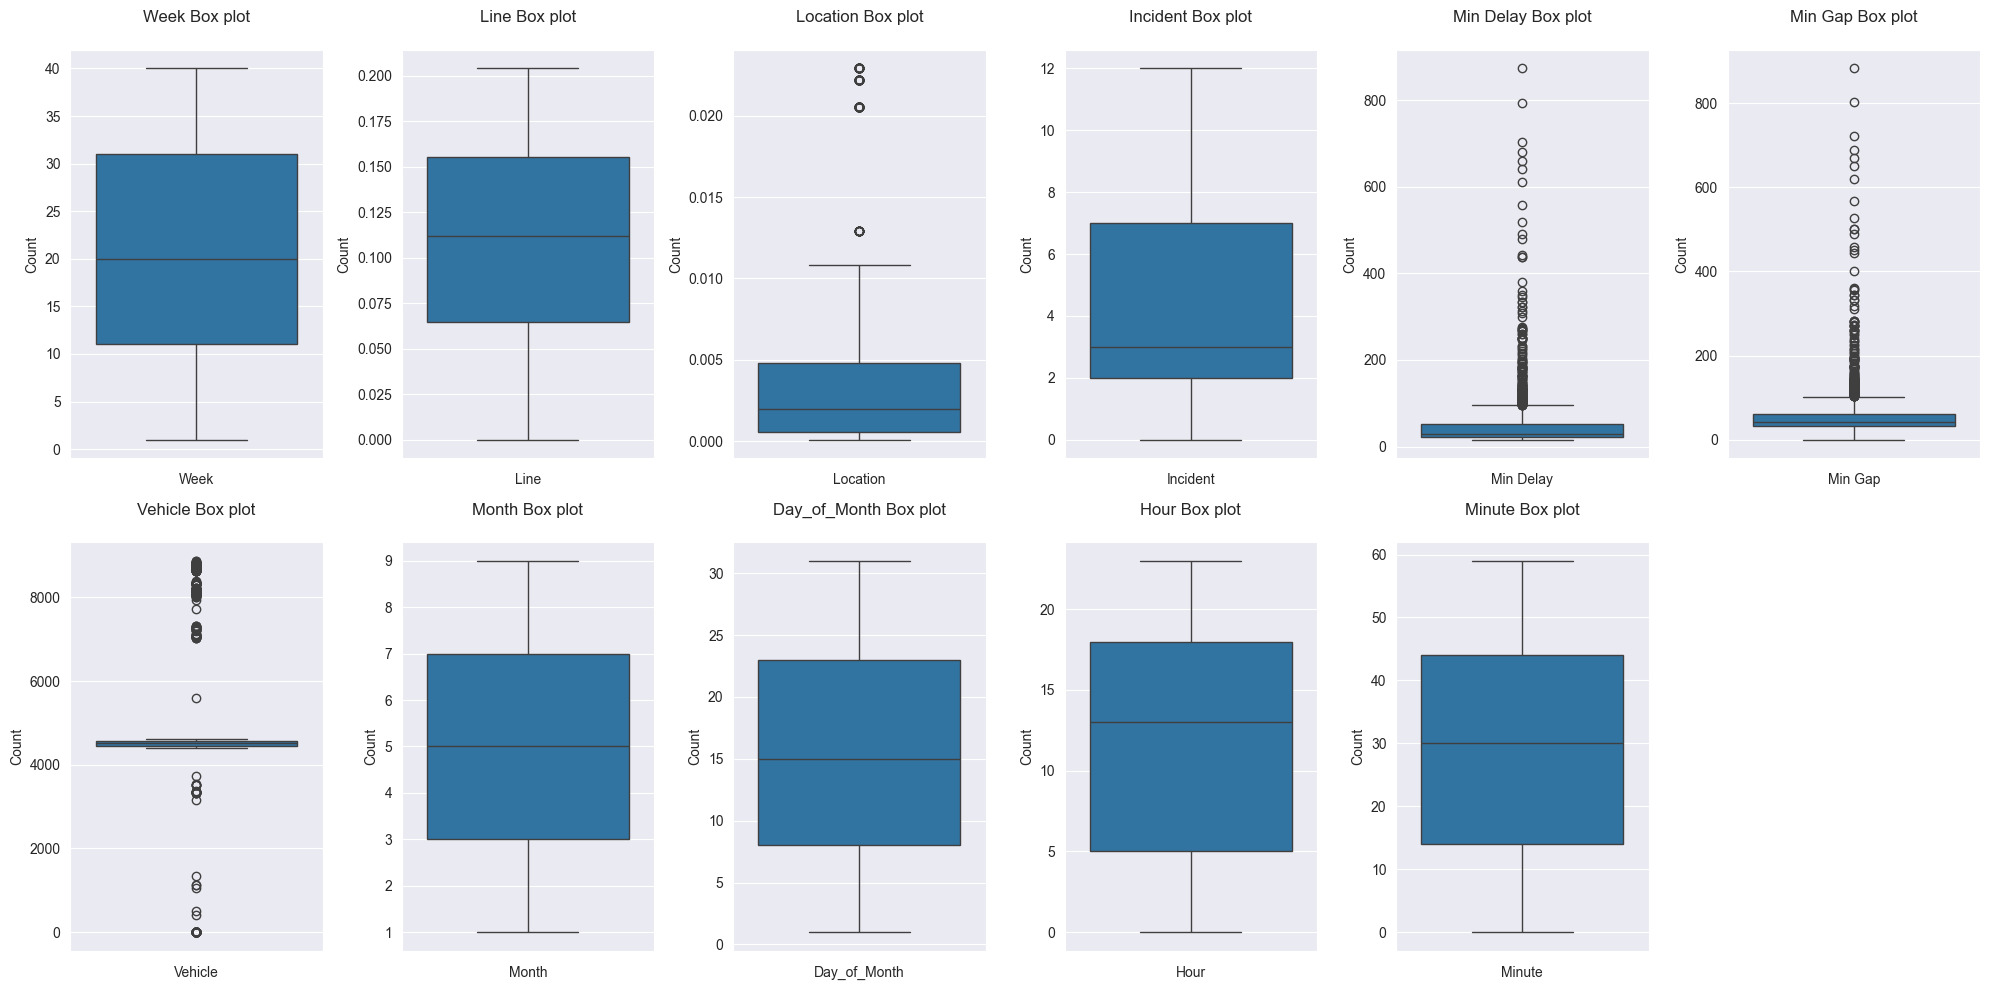

In [8]:
graficar_num = ['Week', 'Line', 'Location', 'Incident', 'Min Delay', 'Min Gap', 'Vehicle', 'Month', 'Day_of_Month', 'Hour', 'Minute']
plt.figure(figsize=(20, 10))

for idx, feature in enumerate(graficar_num, 1):
    plt.subplot(2, 6, idx)
    sns.boxplot(data=df, y=feature)
    plt.title(f'{feature} Box plot', pad=20)
    plt.xlabel(feature)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [9]:
df["Min Delay"].value_counts()

Min Delay
20     247
30     146
17      87
16      76
25      73
      ... 
358      1
873      1
196      1
345      1
611      1
Name: count, Length: 181, dtype: int64

In [10]:
df["Year"].value_counts()

Year
2024    2271
Name: count, dtype: int64

In [11]:
df.drop("Year", axis=1, inplace=True)  # axis=1 is preferred over axis="1"
df.head()

,Week,Line,Location,Incident,Min Delay,Min Gap,Vehicle,has_delay,Month,Day_of_Month,Hour,Minute,Bound_B,Bound_E,Bound_N,Bound_S,Bound_W
1,1,0.126664,0.000361,3,52,72,4461,1,1,1,3,6,0,1,0,0,0
3,1,0.126664,0.020566,11,37,0,4551,1,1,1,3,53,0,0,0,0,1
4,1,0.002645,0.005412,2,78,93,8116,1,1,1,4,27,0,1,0,0,0
5,1,0.203903,0.000090,2,74,84,3531,1,1,1,4,33,0,1,0,0,0
6,1,0.203903,0.000631,2,39,49,4516,1,1,1,4,39,0,0,0,0,1


In [12]:
df['TimeOfDay'] = df['Hour'] * 60 + df['Minute']
df.drop("Hour", axis=1, inplace=True)
df.drop("Minute", axis=1, inplace=True)
df.drop("has_delay", axis=1, inplace=True)
df.drop("Week", axis=1, inplace=True)
features = ['Month', 'Line', 'Location', 'Incident', 'TimeOfDay', 'Vehicle', 'Day_of_Month',
               'Bound_B', 'Bound_E', 'Bound_N', 'Bound_S', 'Bound_W']

In [13]:
df.corr()

,Line,Location,Incident,Min Delay,Min Gap,Vehicle,Month,Day_of_Month,Bound_B,Bound_E,Bound_N,Bound_S,Bound_W,TimeOfDay
Line,1.000000,0.033539,-0.037827,0.005208,-0.018275,-0.004499,0.025327,0.019342,-0.017217,0.006559,-0.036386,-0.016878,0.038074,0.133731
Location,0.033539,1.000000,0.062372,-0.071355,-0.071414,0.007000,-0.015074,0.005959,0.000059,-0.150042,0.062127,0.035055,-0.090032,-0.064712
Incident,-0.037827,0.062372,1.000000,-0.144720,-0.143821,0.069109,-0.040599,0.010566,-0.015669,-0.031547,0.063572,0.066567,-0.026977,-0.096194
Min Delay,0.005208,-0.071355,-0.144720,1.000000,0.965567,-0.048198,0.018785,0.006187,-0.004174,0.008267,-0.023335,-0.040413,0.005484,0.024355
Min Gap,-0.018275,-0.071414,-0.143821,0.965567,1.000000,-0.037803,0.026255,0.002204,-0.004207,0.006363,-0.025957,-0.038896,0.011104,-0.007446
Vehicle,-0.004499,0.007000,0.069109,-0.048198,-0.037803,1.000000,-0.035390,0.018619,-0.003059,0.008933,0.018644,0.040623,0.039206,-0.057990
Month,0.025327,-0.015074,-0.040599,0.018785,0.026255,-0.035390,1.000000,0.030413,-0.016841,0.015894,-0.017171,-0.002424,0.004237,-0.004665
Day_of_Month,0.019342,0.005959,0.010566,0.006187,0.002204,0.018619,0.030413,1.000000,0.022429,0.020253,-0.013253,-0.031935,-0.003663,0.006794
Bound_B,-0.017217,0.000059,-0.015669,-0.004174,-0.004207,-0.003059,-0.016841,0.022429,1.000000,-0.015733,-0.006960,-0.006540,-0.014344,-0.022447
Bound_E,0.006559,-0.150042,-0.031547,0.008267,0.006363,0.008933,0.015894,0.020253,-0.015733,1.000000,-0.248581,-0.233583,-0.512286,0.043033


<Axes: >

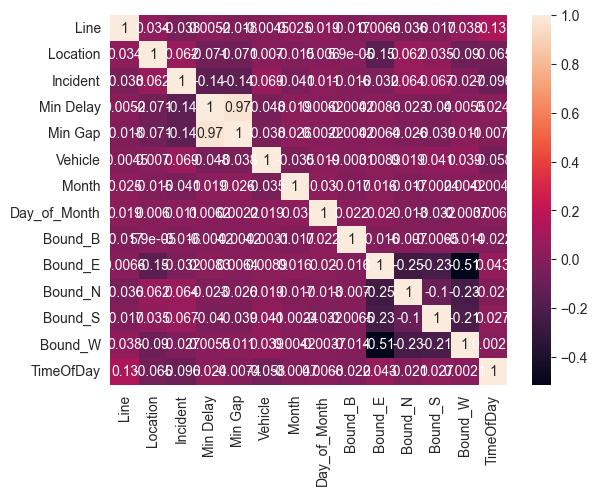

In [14]:
sns.heatmap(df.corr(),annot=True)

<Axes: xlabel='Min Delay', ylabel='Density'>

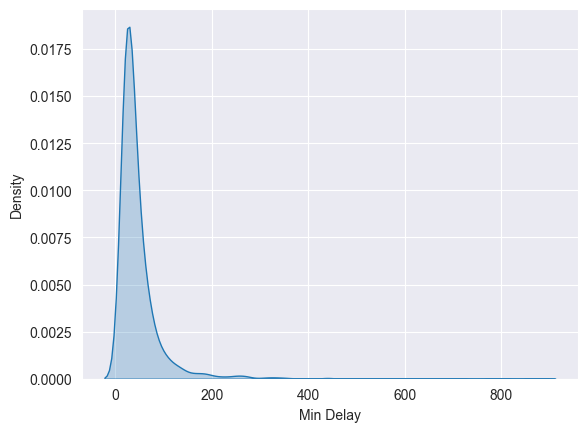

In [15]:
sns.kdeplot(df,x="Min Delay", fill=True)

<Axes: ylabel='Min Delay'>

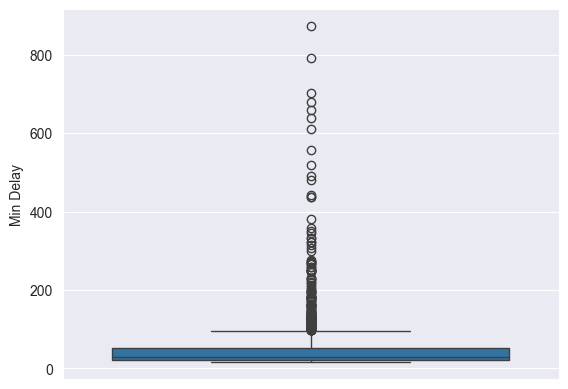

In [16]:
sns.boxplot(df,y="Min Delay")

In [17]:
df[['Min Delay', 'Min Gap']].describe()

,Min Delay,Min Gap
count,2271.000000,2271.000000
mean,48.084985,58.315720
std,60.781412,61.452645
min,16.000000,0.000000
25%,21.000000,32.000000
50%,30.000000,42.000000
75%,51.000000,60.000000
max,873.000000,883.000000


In [18]:
df['Min Delay'].corr(df['Min Gap'])
correlation = df['Min Delay'].corr(df['Min Gap'])
print(f"\nCorrelation betweena Min Delay and Min Gap: {correlation:.2f}")


Correlation betweena Min Delay and Min Gap: 0.97


<Axes: ylabel='Min relation'>

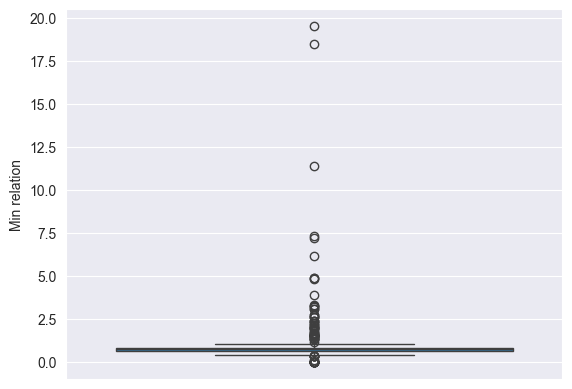

In [19]:
df["Min relation"] = np.where(
    df["Min Gap"] == 0,  # condition for denominator being zero
    0,  # value to use when denominator is zero
    df["Min Delay"]/df["Min Gap"]  # normal division otherwise
)

sns.boxplot(y="Min relation", data=df)

Original dataset size: 2271
After removing outliers: 2182

Summary statistics for cleaned Min relation:
count    2182.000000
mean        0.745766
std         0.129655
min         0.400000
25%         0.666667
50%         0.750000
75%         0.843750
max         1.050000
Name: Min relation, dtype: float64


Text(0, 0.5, 'Min Delay / Min Gap Ratio')

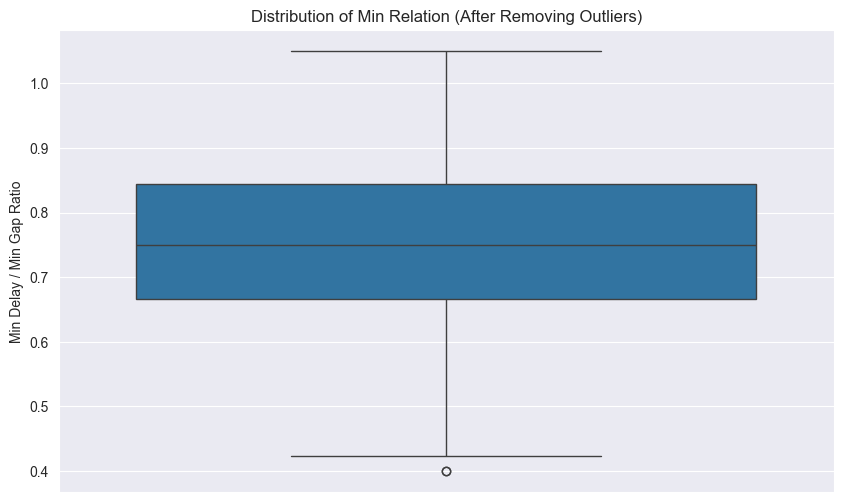

In [20]:
import pandas as pd
import numpy as np

def remove_outliers_iqr(df, column, k=1.5):
    """
    Remove outliers using the IQR method

    Parameters:
    df: DataFrame
    column: str, column name to check for outliers
    k: float, multiplier for IQR (default=1.5)

    Returns:
    DataFrame with outliers removed
    """
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - k * IQR
    upper_bound = Q3 + k * IQR

    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Remove outliers from Min relation
df_clean = remove_outliers_iqr(df, 'Min relation')

# Print summary statistics before and after
print("Original dataset size:", len(df))
print("After removing outliers:", len(df_clean))
print("\nSummary statistics for cleaned Min relation:")
print(df_clean['Min relation'].describe())

# Optionally, if you want to clean the original metrics as well
df_very_clean = df_clean[
    (df_clean['Min Delay'] <= df_clean['Min Delay'].quantile(0.95)) &
    (df_clean['Min Gap'] <= df_clean['Min Gap'].quantile(0.95))
]

# Create visualization of cleaned data
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_clean, y='Min relation')
plt.title('Distribution of Min Relation (After Removing Outliers)')
plt.ylabel('Min Delay / Min Gap Ratio')

In [21]:
df = df_very_clean

In [22]:
df.drop("Min Gap", axis=1, inplace=True)
df.drop("Min Delay", axis=1, inplace=True)

/var/folders/nz/ntbk00f557jfbvm0fp_h8yyh0000gn/T/ipykernel_35647/2323662494.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop("Min Gap", axis=1, inplace=True)
/var/folders/nz/ntbk00f557jfbvm0fp_h8yyh0000gn/T/ipykernel_35647/2323662494.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop("Min Delay", axis=1, inplace=True)


In [23]:
#sns.boxplot(df,y="Min Gap", hue="Min Delay")

In [24]:
df["Min relation"].describe()

count    2072.000000
mean        0.734756
std         0.123511
min         0.400000
25%         0.666667
50%         0.750000
75%         0.830508
max         1.050000
Name: Min relation, dtype: float64

In [25]:
X = df.drop(df.columns[-1],axis=1)
y = df['Min relation']

<Axes: >

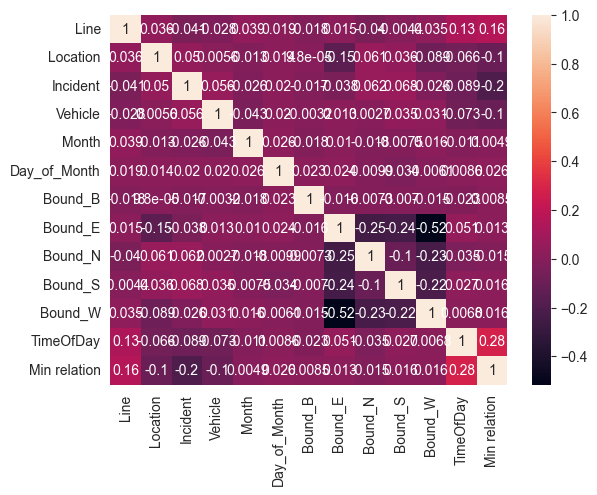

In [26]:
sns.heatmap(df.corr(),annot=True)

In [27]:
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
from sklearn.pipeline import Pipeline

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create pipelines for different models
pipelines = {
    'rf': Pipeline([
        ('scaler', RobustScaler()),
        ('model', RandomForestRegressor(random_state=42))
    ]),
    'gb': Pipeline([
        ('scaler', RobustScaler()),
        ('model', GradientBoostingRegressor(random_state=42))
    ]),
    'xgb': Pipeline([
        ('scaler', RobustScaler()),
        ('model', xgb.XGBRegressor(random_state=42))
    ])
}

# Define parameter grids for each model
param_grids = {
    'rf': {
        'model__n_estimators': [100, 200],
        'model__max_depth': [10, 20, None],
        'model__min_samples_split': [2, 5]
    },
    'gb': {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.01, 0.1],
        'model__max_depth': [3, 5]
    },
    'xgb': {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.01, 0.1],
        'model__max_depth': [3, 5]
    }
}

# Train and evaluate models
best_models = {}
results = {}

for name, pipeline in pipelines.items():
    # Perform grid search with cross-validation
    grid_search = GridSearchCV(
        pipeline,
        param_grids[name],
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )

    grid_search.fit(X_train, y_train)
    best_models[name] = grid_search.best_estimator_

    # Evaluate on test set
    y_pred = grid_search.predict(X_test)
    results[name] = {
        'mse': mean_squared_error(y_test, y_pred),
        'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
        'mae': mean_absolute_error(y_test, y_pred),
        'r2': r2_score(y_test, y_pred),
        'best_params': grid_search.best_params_
    }

# Find best model
best_model_name = min(results, key=lambda x: results[x]['rmse'])
best_model = best_models[best_model_name]

# Print results
for name in results:
    print(f"\n{name.upper()} Results:")
    print(f"RMSE: {results[name]['rmse']:.2f}")
    print(f"R2 Score: {results[name]['r2']:.2f}")
    print("Best Parameters:", results[name]['best_params'])

print(f"\nBest Model: {best_model_name.upper()}")


RF Results:
RMSE: 0.10
R2 Score: 0.27
Best Parameters: {'model__max_depth': 10, 'model__min_samples_split': 5, 'model__n_estimators': 200}

GB Results:
RMSE: 0.10
R2 Score: 0.31
Best Parameters: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 100}

XGB Results:
RMSE: 0.10
R2 Score: 0.29
Best Parameters: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 100}

Best Model: GB


Realizando análisis exploratorio...


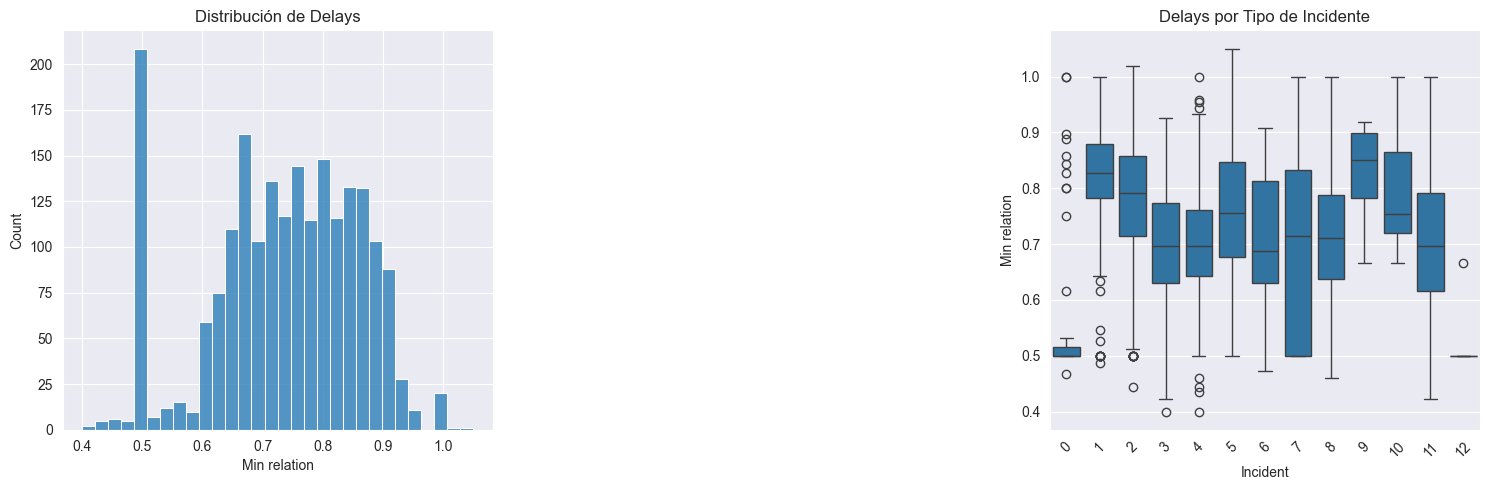

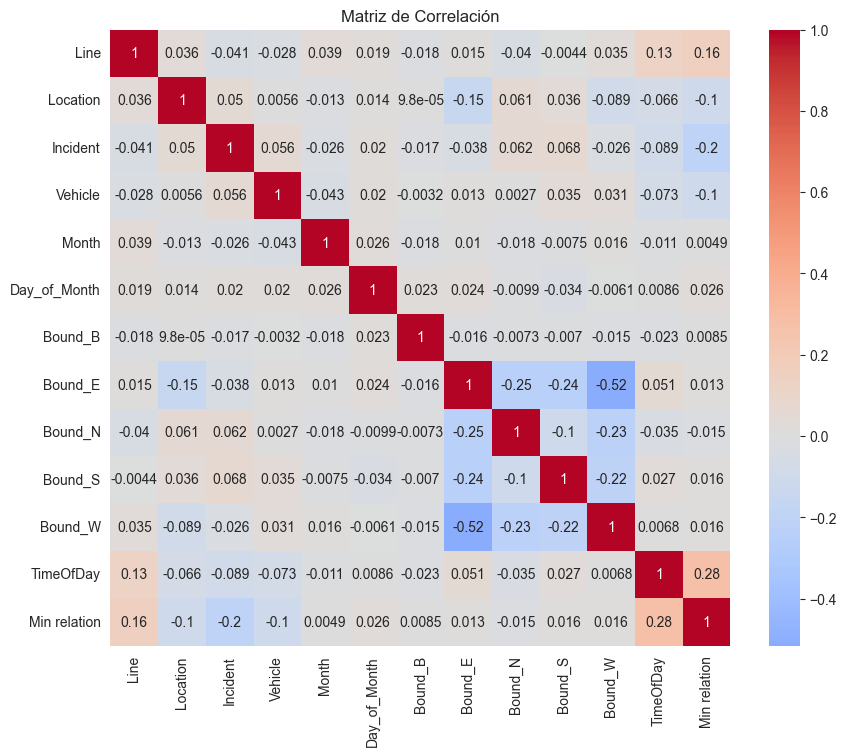

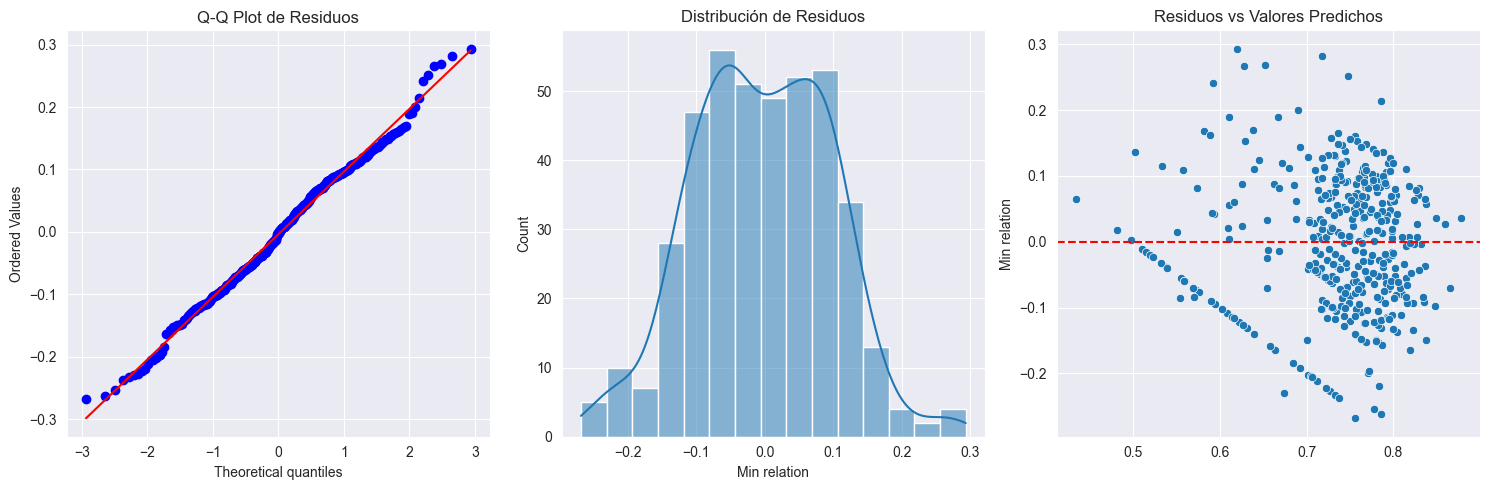


Test de Shapiro-Wilk para Normalidad:
Estadístico: 0.9934
P-valor: 0.0676


In [33]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.diagnostic import het_breuschpagan

def exploratory_analysis(df):
    plt.figure(figsize=(15, 5))

    # Distribución de delays
    plt.subplot(131)
    sns.histplot(data=df, x='Min relation', bins=30)
    plt.title('Distribución de Delays')

    # Delays por tipo de incidente
    plt.subplot(133)
    sns.boxplot(data=df, x='Incident', y='Min relation')
    plt.xticks(rotation=45)
    plt.title('Delays por Tipo de Incidente')

    plt.tight_layout()
    plt.show()

    # Matriz de correlación
    plt.figure(figsize=(10, 8))
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    correlation_matrix = df[numeric_cols].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Matriz de Correlación')
    plt.show()

def check_model_assumptions(y_true, y_pred, residuals):
    fig = plt.figure(figsize=(15, 5))

    # Q-Q plot
    ax1 = fig.add_subplot(131)
    stats.probplot(residuals, dist="norm", plot=ax1)
    ax1.set_title("Q-Q Plot de Residuos")

    # Histograma de residuos
    ax2 = fig.add_subplot(132)
    sns.histplot(residuals, kde=True, ax=ax2)
    ax2.set_title("Distribución de Residuos")

    # Residuos vs Valores Predichos
    ax3 = fig.add_subplot(133)
    sns.scatterplot(x=y_pred, y=residuals, ax=ax3)
    ax3.axhline(y=0, color='r', linestyle='--')
    ax3.set_title("Residuos vs Valores Predichos")

    plt.tight_layout()
    plt.show()

    # Test de Shapiro-Wilk
    shapiro_test = stats.shapiro(residuals)
    print("\nTest de Shapiro-Wilk para Normalidad:")
    print(f"Estadístico: {shapiro_test[0]:.4f}")
    print(f"P-valor: {shapiro_test[1]:.4f}")



# Preparar los datos
df_clean = df

# Realizar análisis exploratorio
print("Realizando análisis exploratorio...")
exploratory_analysis(df_clean)

# Preparar variables para el modelo
X = df_clean[features]
y = df_clean['Min relation']

# Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalar las variables
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Entrenar el modelo
model = GradientBoostingRegressor()
model.fit(X_train_scaled, y_train)

# Realizar predicciones
y_pred_train = model.predict(X_train_scaled)
y_pred_test = model.predict(X_test_scaled)

# Calcular residuos
residuos = y_test - y_pred_test

# Verificar supuestos del modelo
check_model_assumptions(y_test, y_pred_test, residuos)
